---
**License**

 BounceVecPert

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 BounceVecPert\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

# Vector field in bouncing cosmology

In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a dust-like fluid.

The scale factor for this model is given by:
\begin{equation}
\frac{a(\eta)}{a_0} = \frac{1}{x_b} \left[\eta^2\gamma+\sqrt{1+\left(\frac{\eta}{\eta_b}\right)^2}\right], \quad x \equiv \frac{a_0}{a}, \quad x_b \equiv \frac{a_0}{a_b},
\end{equation}
where $a_b$ gives the value of the scale factor at the bounce ($\eta = 0$), and $\eta_b$ the bounce time-scale. We can write the constants $\gamma$ and $\eta_b$ in terms of the usual densities $\Omega_r$ and $\Omega_m$, computing the Hubble function $H = a^\prime/a^2$ away from the bounce phase $\eta\gg\eta_b$ (${}^\prime$ represents derivatives with respect to the conformal time $\eta$), i.e.,
\begin{equation}
H^2=\left(\frac{a^\prime}{a^2}\right)^2 = \frac{1}{a_0^2}\left(\frac{4\gamma x^3}{x_b}+\frac{x^4}{x_b^2\eta_b^2}\right) = R_{H}^{-2}a_0^{-2}\left(\Omega_m x^3 + \Omega_r x^4\right) \quad \Rightarrow \quad \gamma = \frac{x_b\Omega_m}{4R_H^2}, \quad \eta_b = \frac{R_H}{x_b\sqrt{\Omega_r}},
\end{equation}
where $R_H \equiv 1/(H_0a_0)$ is the Hubble radius today and $\Omega_m$ and $\Omega_r$ are the dimensionless densities today.

One can see that the problem can be parametrized by $\Omega_m$, $\Omega_r$ and $x_b$ by writing all quantities in units of the conformal time today:
\begin{equation}
\bar\eta \equiv \frac{\eta}{R_H} , \quad \bar\gamma \equiv R_H^2\gamma = \frac{x_b\Omega_m}{4}, \quad \bar\eta_b \equiv \frac{\eta_b}{R_H} = \frac{1}{x_b\sqrt{\Omega_r}}.
\end{equation}
Now, the scale factor is given by 
\begin{equation}
\frac{a(\bar\eta)}{a_0} = \frac{1}{x_b} \left[\bar\eta^2\bar\gamma+\sqrt{1+\left(\frac{\bar\eta}{\bar\eta_b}\right)^2}\right].
\end{equation}
From here on, we are dropping the over-bars from all quantities and always assume the quantities are written in unit of conformal time today.


## Loading NumCosmo

The first step is to load both NumCosmo and NumCosmoMath libraries.

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

# Figure utilities

In [2]:
fig_width_pt  = 246.0 * 2.0                 # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0 / 72.27                 # Convert pt to inch
golden_mean   = (math.sqrt (5) - 1.0) / 2.0 # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # width in inches
fig_height    = fig_width*golden_mean       # height in inches
fig_size      = [ fig_width, fig_height ]

params = {
          'axes.labelsize' : 10,
          'font.size'      : 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex'    : True,
          'figure.figsize' : fig_size
         }

mpl.rcParams.update (params)

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base == 1.0:
          if exponent == 0.0:
            return r"1"
          else:
            return r"10^{{{1}}}".format (int(exponent))
        elif exponent == 0.0:
          return r"{0}".format (base)
        else:
          return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

# Initializing the library

In [3]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# Complex structure quantization object

Below we define our object as a child of the complex structure quantization object Ncm.CSQ1D

In [4]:
class PyCSQ1DVecPert (Ncm.CSQ1D):
  def __init__ (self, Omega_m = 0.3, Omega_r = 1.0e-4, xb = 1.0e25, b = 1.0, h = 0.7):
    Ncm.CSQ1D.__init__ (self)

    self.Omega_m = Omega_m
    self.Omega_r = Omega_r
    self.xb      = xb
    self.b       = b
    self.RH      = (Ncm.C.c () / (1.0e5 * h)) # Hubble radius in units of Mpc
    self.gamma   = 0.25 * xb * Omega_m
    self.etab    = 1.0 / (xb * math.sqrt (Omega_r))
    self.lp_RH   = 1.0 / (Ncm.C.hubble_radius_hm1_planck () / h)

  def y_eta (self, eta):
    eta2  = eta * eta
    etab2 = self.etab**2
    s1    = math.sqrt (1.0 + eta2 / etab2)

    return (eta2 * self.gamma + s1) / self.xb

  def eta_y (self, y):
    xb    = self.xb
    g     = self.gamma
    etab2 = self.etab**2
    denon = (1.0 + 2.0 * xb * y * g * etab2 + math.sqrt (1.0 + 4.0 * g * etab2 * (xb * y + g * etab2)))
    numer = ((xb * y)**2 - 1.0) * 2.0 * etab2
    return math.sqrt (numer / denon)

  def H_eta (self, eta):
    eta2  = eta**2
    etab2 = self.etab**2
    s1    = math.sqrt (1.0 + eta2 / etab2)
    y_xb  = eta2 * self.gamma + s1
    yp_xb = (2.0 * self.gamma + 1.0 / (etab2 * s1)) * eta

    return yp_xb / y_xb

  def do_eval_xi (self, model, eta, k):
    return 2.0 * math.log (self.y_eta (eta)) + math.log (self.b * k)

  def do_eval_nu (self, model, eta, k):
    return self.b * k

  def do_eval_F1 (self, model, eta, k):
    return 2.0 * self.H_eta (eta) / (2.0 * self.b * k)

  def do_eval_F2 (self, model, eta, k):
    eta2   = eta**2
    etab2  = self.etab**2
    s1     = math.sqrt (1.0 + eta2 / etab2)
    y_xb   = eta2 * self.gamma + s1
    yp_xb  = (2.0 * self.gamma + 1.0 / (etab2 * s1)) * eta
    ypp_xb = (2.0 * self.gamma + 1.0 / (etab2 * s1**3))
    H_eta  = yp_xb / y_xb
    F1     = 2.0 * H_eta / (2.0 * self.b * k)
    T1     = 2.0 * ypp_xb / y_xb

    return T1 / (2.0 * self.b * k)**2 - 0.5 * F1 * F1

  def do_prepare (self, model):
    pass 



In [5]:
csq1d = PyCSQ1DVecPert (b = 1.0e-3, xb = 5.0e29)

ki    = 1.0e0
kf    = 1.0e9
k_a   = np.geomspace (ki, kf, 4)

csq1d.set_k (kf)
(Found2, tf) = csq1d.find_adiab_time_limit (None, +1.0e-25, +1.0e15, 1.0e-5)

print (Found2, tf)

(Found1, ti) = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-5)

print (Found1, ti)

True 1.2571962747174702e-05
True -1.2571962747174702e-05


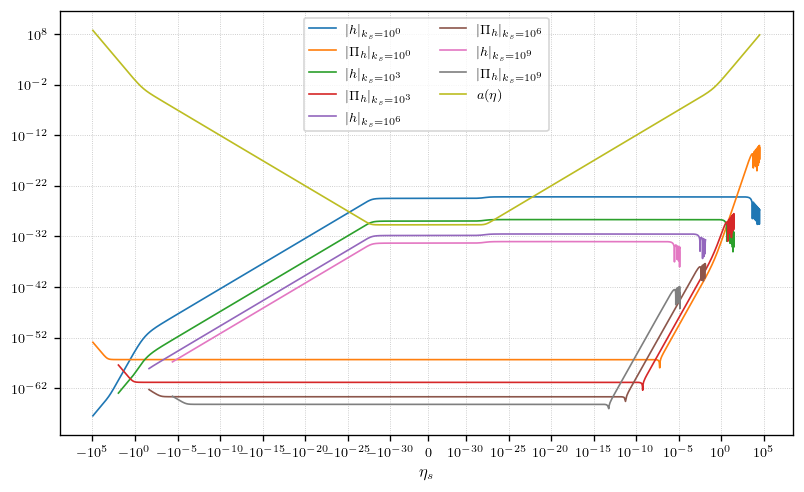

In [6]:
fig = plt.figure (dpi = 120)

max_etaf = -1.0e300
min_etai = +1.0e300

for k in k_a:
  csq1d.set_k (k)
  csq1d.set_reltol (1.0e-12)
  csq1d.set_save_evol (True)

  (Found1, etai)  = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-7)
  (Found2, etafa) = csq1d.find_adiab_time_limit (None, +1.0e-25, +1.0e15, 1.0e0)
  etaf = etafa * 20

  csq1d.set_ti (etai)
  csq1d.set_tf (etaf)
  csq1d.set_init_cond_adiab (None, etai)
  csq1d.prepare ()

  min_etai = min (etai, min_etai)
  max_etaf = max (etaf, max_etaf)

  eta_a, eta_s = csq1d.get_time_array ()
  y_a          = []
  Abs_phi2_a   = []
  Abs_Pphi2_a  = []

  eta_a = np.array (eta_a)

  for eta in eta_a:
    (J11, J12, J22) = csq1d.get_J_at (None, eta)
    
    f = 16.0 * math.pi * csq1d.lp_RH**2
    
    Abs_phi2_a.append (f * 0.5 * J11)
    Abs_Pphi2_a.append (f * 0.5 * J22)

  y_a         = np.array (y_a)
  Abs_phi2_a  = np.array (Abs_phi2_a)
  Abs_Pphi2_a = np.array (Abs_Pphi2_a)

  mylw    = 1

  plt.plot (eta_a, np.sqrt (Abs_phi2_a), lw=mylw, label = r'$\vert h\vert_{k_s = 10^{%0.2g}}$' % math.log10 (k))
  plt.plot (eta_a, np.sqrt (Abs_Pphi2_a), lw=mylw, label = r'$\vert\Pi_h\vert_{k_s = 10^{%0.2g}}$' % math.log10 (k))

etac_a = np.geomspace (min_etai, -eta_s, 1000)
etae_a = np.geomspace (eta_s, max_etaf, 1000)
eta_a  = np.concatenate ((etac_a, etae_a))
a_a    = np.array ([csq1d.y_eta (eta) for eta in eta_a])
a_b    = min (a_a)

plt.plot (eta_a, a_a, lw=mylw, label = r'$a(\eta)$')

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)
plt.xscale('symlog', linthresh = 1.0e-30, linscale = 4.0)
plt.yscale('log')
plt.xlabel ("$\eta_s$")

fig.tight_layout ()

plt.savefig('VecPertModeEvol.pdf')
plt.show ()



In [7]:
print (csq1d.y_eta (1.0e-29))
print (csq1d.eta_y (1.0e-29))
print (csq1d.eta_y (csq1d.y_eta (1.0e-3)))

2.0024984394500786e-30
9.797958971132712e-28
0.0009999999999999998


Computing k = 1
Computing k = 1000
Computing k = 1e+06
Computing k = 1e+09


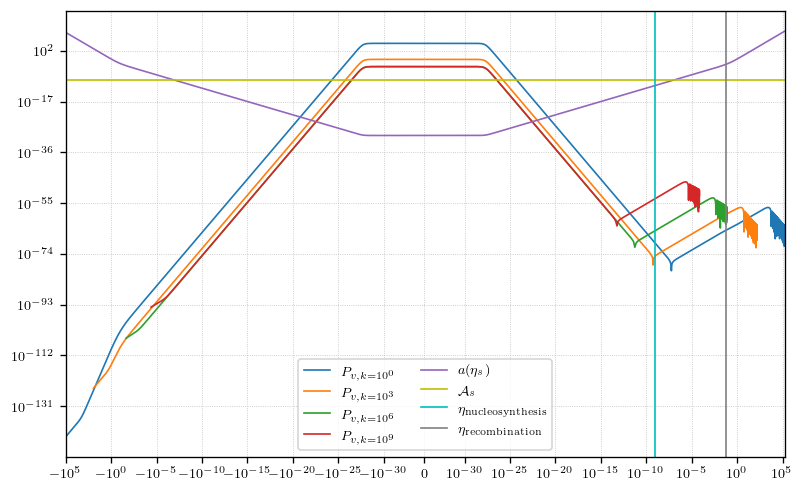

In [8]:
fig = plt.figure (dpi = 120)

max_etaf = -1.0e300
min_etai = +1.0e300

for k in k_a:
  csq1d.set_k (k)
  csq1d.set_reltol (1.0e-12)
  csq1d.set_save_evol (True)
  print ("Computing k = %g" % k)

  (Found1, etai)  = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-7)
  (Found2, etafa) = csq1d.find_adiab_time_limit (None, +1.0e-25, +1.0e15, 1.0e0)
  etaf = etafa * 100

  min_etai = min (etai, min_etai)
  max_etaf = max (etaf, max_etaf)

  csq1d.set_ti (etai)
  csq1d.set_tf (etaf)
  csq1d.set_init_cond_adiab (None, etai)
  csq1d.prepare ()

  eta_a, eta_s = csq1d.get_time_array ()
  Php_a        = []

  eta_a = np.array (eta_a)

  for eta in eta_a:
    (J11, J12, J22) = csq1d.get_J_at (None, eta)
    y = csq1d.y_eta (eta)
    f = 8.0 * csq1d.lp_RH**2 / math.pi
    
    Php_a.append (f * k * 0.5 * J22 / y**4)

  Php_a = np.array (Php_a)
  mylw = 1

  plt.plot (eta_a, Php_a, lw=mylw, label = r'$P_{v,k = 10^{%0.2g}}$' % math.log10 (k))
  eta = 0.0
  (J11, J12, J22) = csq1d.get_J_at (None, eta)
  y = csq1d.y_eta (eta)
  f = 8.0 * csq1d.lp_RH**2 / math.pi

etac_a = np.geomspace (min_etai, -eta_s, 1000)
etae_a = np.geomspace (eta_s, max_etaf, 1000)
eta_a = np.concatenate ((etac_a, etae_a))
a_a    = np.array ([csq1d.y_eta (eta) for eta in eta_a])
a_b    = min (a_a)

plt.plot (eta_a, a_a, lw=mylw, label = r'$a(\eta_s)$')
plt.axhline (y = 1.0e-9, c = 'y', lw = mylw, label = "$\mathcal{A}_s$")
plt.axvline (x = csq1d.eta_y (1.0 / 1.0e11), lw=mylw, label = "$\eta_\mathrm{nucleosynthesis}$", c = 'c')
plt.axvline (x = csq1d.eta_y (1.0 / 1100.0), lw=mylw, label = "$\eta_\mathrm{recombination}$", c = 'gray')

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best", ncol = 2)
plt.xscale('symlog', linthresh = 1.0e-30, linscale = 4.0)
plt.yscale('log')

fig.tight_layout ()

plt.savefig('VecPertModeEvolP.pdf')
plt.show ()


In [ ]:
plt.figure (dpi = 120)

k_a   = np.geomspace (ki, kf, 20)
Php_a = []

etaf = csq1d.eta_y (1.0 / (1.0 + 1100.0))

for k in k_a:
  csq1d.set_k (k)
  csq1d.set_reltol (1.0e-12)
  csq1d.set_save_evol (True)
  print ("Computing k = %g" % k)

  (Found1, etai)  = csq1d.find_adiab_time_limit (None, -1.0e15, -1.0e-25, 1.0e-7)
    
  csq1d.set_ti (etai)
  csq1d.set_tf (etaf)
  csq1d.set_init_cond_adiab (None, etai)
  csq1d.prepare ()
  
  (J11, J12, J22) = csq1d.get_J_at (None, etaf)
  y = csq1d.y_eta (etaf)
  f = 8.0 * k * csq1d.lp_RH**2 / math.pi
  Php_a.append (f * 0.5 * J22 / y**4)


mylw = 1

plt.plot (k_a, Php_a, lw=mylw, label = r'$P_{h^\prime}(%s)$' % latex_float (etaf))

plt.grid (b=True, which='both', linestyle=':', color='0.75', linewidth=0.5)
leg = plt.legend (loc="best")

plt.xscale('log')
plt.yscale('log')

plt.savefig('VecPertPS.pdf')
plt.show ()

nV = math.log (Php_a[1] / Php_a[0]) / math.log (k_a[1] / k_a[0]) + 1.0
AV = (Php_a[0] / (100.0 * k_a[0] / (csq1d.RH))**(nV-1.0))
print ("nV = % 22.15g" % (nV))
print ("AV = % 22.15g" % (AV))


Computing k = 1
Computing k = 2.97635
Computing k = 8.85867
Computing k = 26.3665
Computing k = 78.476
Computing k = 233.572
Computing k = 695.193
Computing k = 2069.14
Computing k = 6158.48
Computing k = 18329.8
Computing k = 54555.9
Computing k = 162378
Computing k = 483293
Computing k = 1.43845e+06
Computing k = 4.28133e+06
Computing k = 1.27427e+07
Computing k = 3.79269e+07
